<a href="https://colab.research.google.com/github/pp23441/Indian-Classical-Music-Analysis/blob/main/Indian_Classical_Music_Analysis_Pruthvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q visualkeras

In [ ]:
pip install scikit-plot

In [ ]:
pip install SpeechRecognition pydub


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from visualkeras import layered_view

# Model
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Speech recognition
import speech_recognition as sr
from pydub import AudioSegment

Class : hiphop


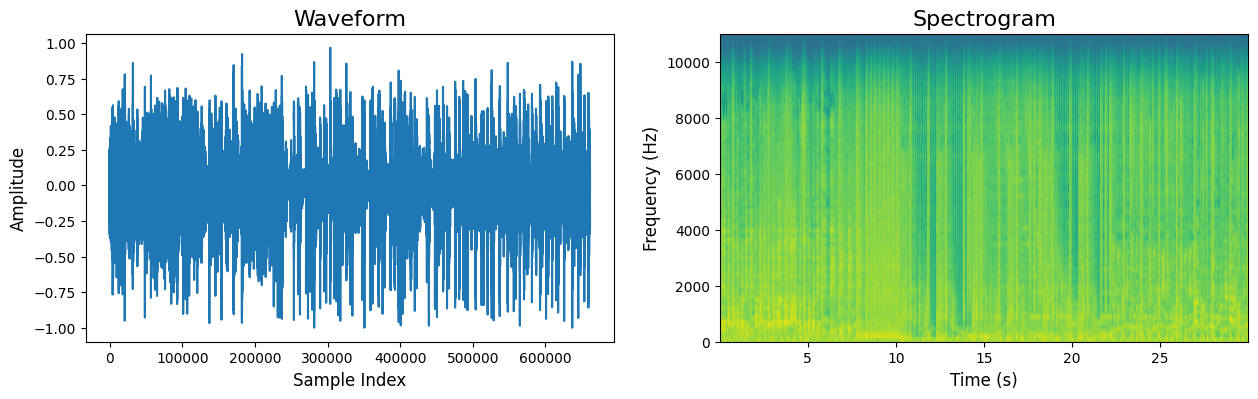

In [ ]:
# Loading VGGish model from TensorFlow Hub
vggish = hub.load('https://tfhub.dev/google/vggish/1')

# Function to get class label from file path
def getClassLabel(filePath):
    # Assuming the class is the folder name containing the audio file
    return os.path.basename(os.path.dirname(filePath))

# Displaying a random waveform and spectrogram
audioFile = '/content/drive/MyDrive/VGG 16 Dataset and Music in wav as well as in MP3 form/Data/genres_original/hiphop/hiphop.00000.wav'
classLabel = getClassLabel(audioFile)
print(f'Class : {classLabel}')

# Loading audio file
waveform, sampleRate = librosa.load(audioFile)

# Displaying audio
# print('Class : \n')
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Displaying waveform
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)

# Displaying spectrogram
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

# Function to extract audio features using MFCC and RMS values
def extractFeatures(audioFile):
    try:
        # Loading audio file
        waveform, sr = librosa.load(audioFile)

        # Trimming silence
        waveform, _ = librosa.effects.trim(waveform)

        # Extracting MFCC features
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13)

        # Extracting RMS values
        rms = librosa.feature.rms(y=waveform)

        # Combining features
        features = np.concatenate((mfcc, rms), axis=0)

        return features.T
    except:
        return None

Processing folder disco: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


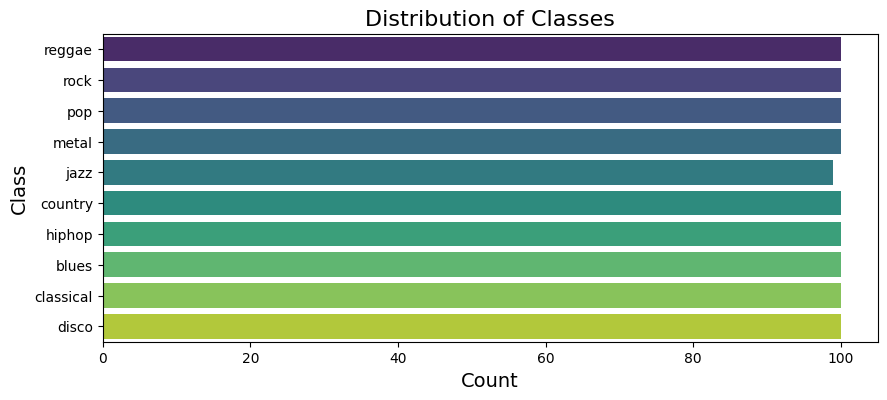

In [ ]:
# Root directory containing the audio files
# Root directory containing the audio files
root = '/content/drive/MyDrive/VGG 16 Dataset and Music in wav as well as in MP3 form/Data/genres_original'
data = []

# Iterating through the folders and files to extract features
for folder in os.listdir(root):
    folderPath = os.path.join(root, folder)
    # Check if the item is a directory before processing
    if os.path.isdir(folderPath):
        for file in tqdm(os.listdir(folderPath), desc = f'Processing folder {folder}'):
            filePath = os.path.join(folderPath, file)
            features = extractFeatures(filePath)

            if features is not None:
                data.append([features, folder])

# Converting list into dataframe
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

# Plotting count distribution of classes
plt.figure(figsize = (10, 4))
sns.countplot(y = data['Class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

# Padding or truncating the arrays to a fixed length
x = data['Features'].tolist()
x = pad_sequences(x, dtype = 'float64', padding = 'post', truncating = 'post')
x.shape

# Encoding class labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Class'])
y = to_categorical(y)

In [ ]:
# Converting list into dataframe
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

,Features,Class
0,"[[-157.82005, 104.29762, -8.149044, 10.019642,...",reggae
1,"[[-242.65182, 112.08275, -16.37442, 23.606548,...",reggae
2,"[[-124.38834, 148.22897, -27.855011, 8.86745, ...",reggae
3,"[[-230.41797, 140.98001, -6.092029, 44.901894,...",reggae
4,"[[-100.10612, 155.08096, -45.158463, 19.936615...",reggae


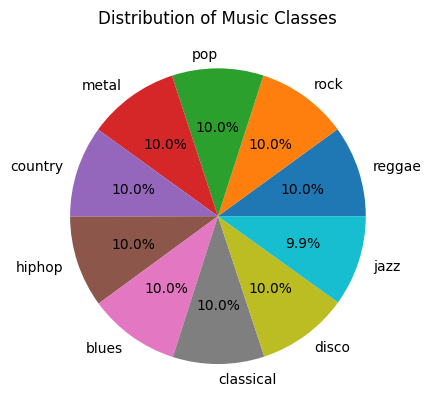

In [ ]:
# title Distribution of Music Classes

import matplotlib.pyplot as plt

data['Class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
_ = plt.title('Distribution of Music Classes')

In [ ]:
# Function to resize MFCC features
def resize_features(features, target_shape=(32, 32)):
    resized_features = []
    for feature in features:
        resized = cv2.resize(feature, target_shape)
        resized_features.append(resized)
    return np.array(resized_features)

# Resizing MFCC features for VGG16
x_resized = resize_features(x, target_shape=(32, 32))

# Reshape the data to match VGG16 expected input shape
x_resized = np.stack([np.tile(f, (3, 1, 1)).T for f in x_resized], axis=0)

#  Train-validation split
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.01, random_state = 0)
trainX_vgg16, testX_vgg16 = train_test_split(x_resized, test_size=0.01, random_state = 0)
trainX_reshaped = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)) # Use the original shape of trainX to calculate the reshaped dimensions.
print(trainX_reshaped.shape)

(989, 1318, 14, 1)


In [ ]:
# LSTM Model
lstm_model = Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1318, 128)         73216     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 10)              

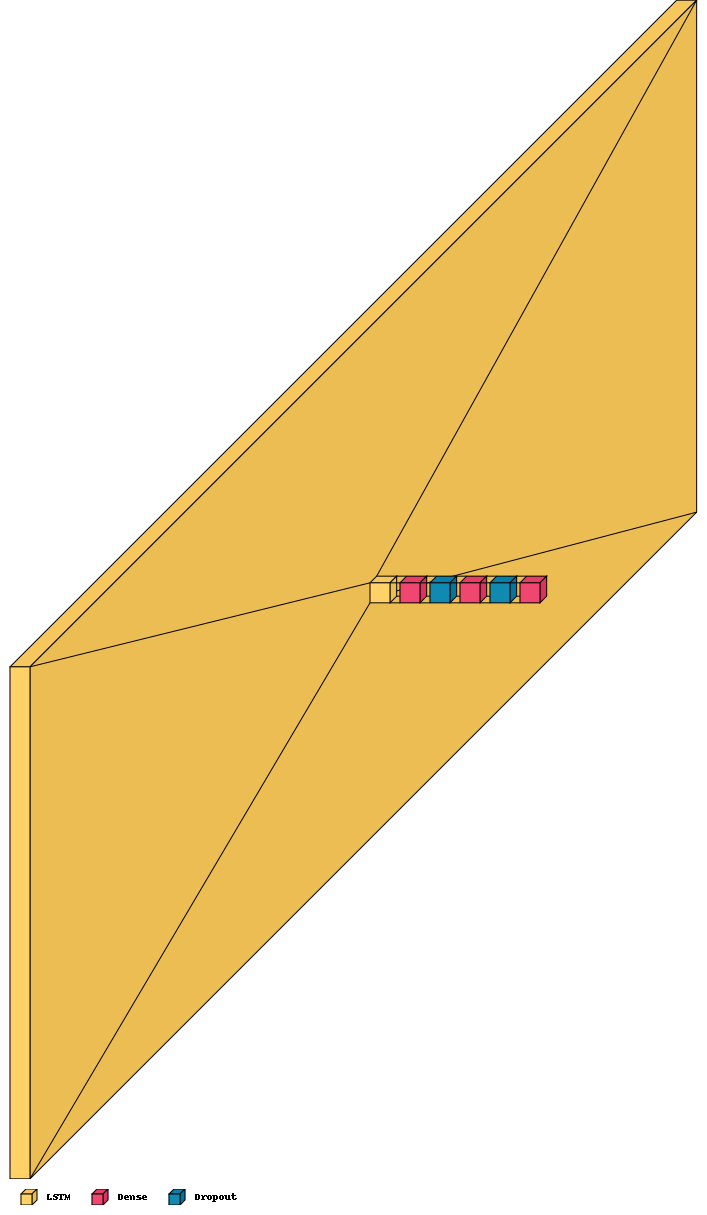

In [ ]:
# Visualizing LSTM model architecture
layered_view(lstm_model, legend=True)

In [ ]:
# VGG16 Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg16_base = VGG16(include_top=False, input_shape=(32, 32, 3))
vgg16_model = Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y.shape[1], activation='softmax')
])

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 256)               131328    
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 14848586 (56.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


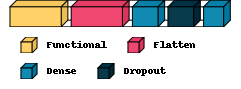

In [ ]:
# Visualizing VGG16 model architecture
layered_view(vgg16_model, legend=True)

In [ ]:
# CNN Model
cnn_model = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(trainX_reshaped.shape[1], trainX_reshaped.shape[2], 1)),
    layers.MaxPooling2D(pool_size=(2, 1), strides=(2, 1)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(y.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 1318, 14, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 659, 14, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 659, 14, 32)       128       
 tchNormalization)                                               
                                                                 
 dropout_29 (Dropout)        (None, 659, 14, 32)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 659, 14, 64)       18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 329, 7, 64)      

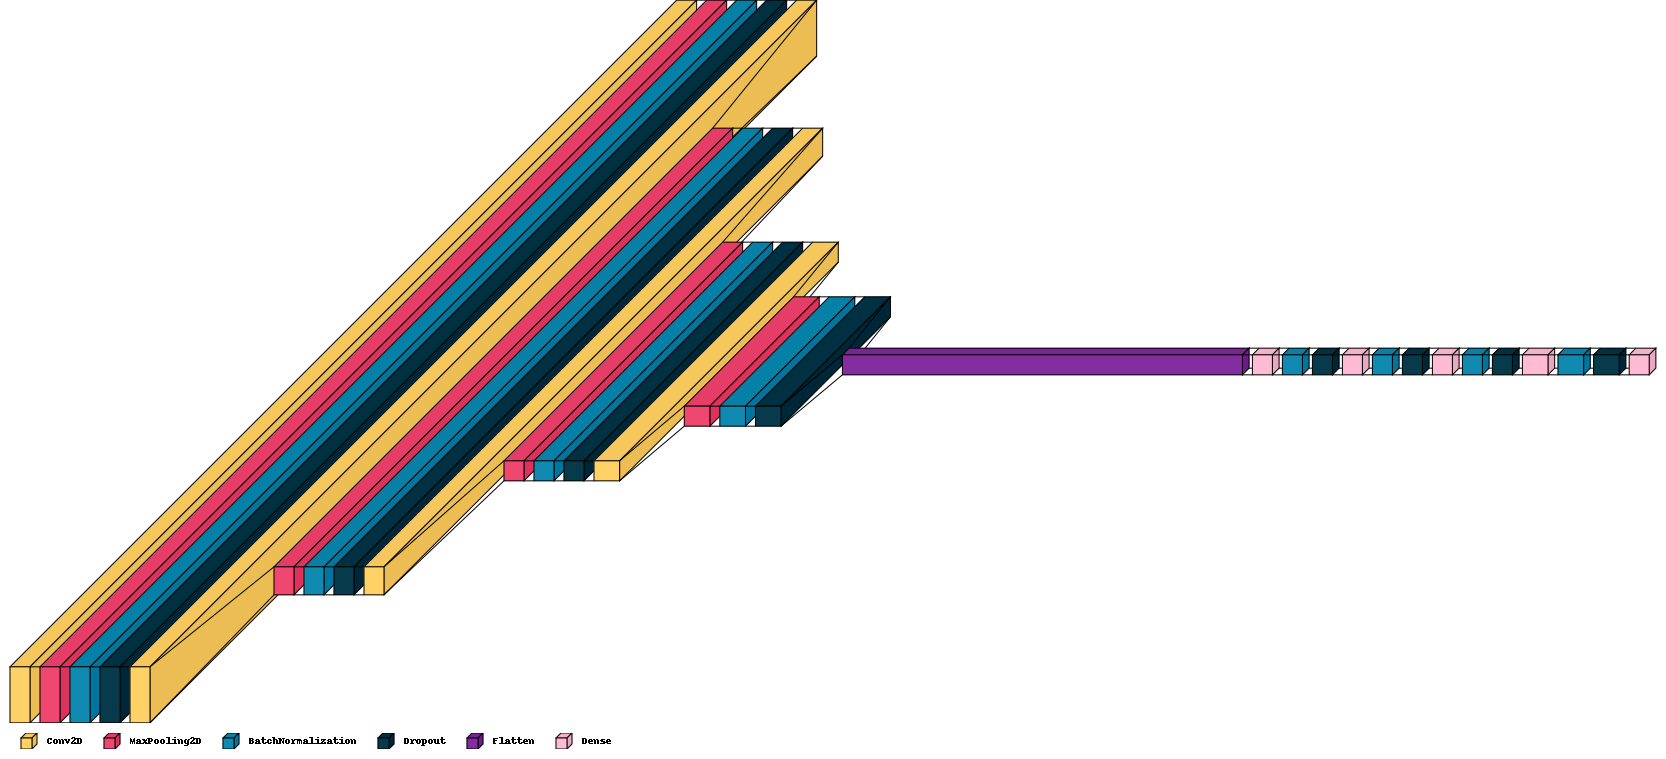

In [ ]:
# Visualizing CNN model architecture
layered_view(cnn_model, legend=True)

In [ ]:
# Early stopping callback
earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

In [ ]:
# Training LSTM model
lstm_history = lstm_model.fit(
    trainX, trainY,
    validation_split=0.2,
    epochs=50,
    callbacks=[earlyStopping],
    batch_size=32
)

Epoch 1/50
25/25 [==============================] - 62s 2s/step - loss: 2.1374 - accuracy: 0.1858 - val_loss: 2.0099 - val_accuracy: 0.2980
Epoch 2/50
25/25 [==============================] - 59s 2s/step - loss: 2.0209 - accuracy: 0.2415 - val_loss: 1.8996 - val_accuracy: 0.3081
Epoch 3/50
25/25 [==============================] - 58s 2s/step - loss: 1.9207 - accuracy: 0.2946 - val_loss: 1.8508 - val_accuracy: 0.3535
Epoch 4/50
25/25 [==============================] - 60s 2s/step - loss: 1.8384 - accuracy: 0.3072 - val_loss: 1.6670 - val_accuracy: 0.3939
Epoch 5/50
25/25 [==============================] - 59s 2s/step - loss: 1.7705 - accuracy: 0.3439 - val_loss: 1.7054 - val_accuracy: 0.3838
Epoch 6/50
25/25 [==============================] - 60s 2s/step - loss: 1.7240 - accuracy: 0.3616 - val_loss: 1.5573 - val_accuracy: 0.4242
Epoch 7/50
25/25 [==============================] - 59s 2s/step - loss: 1.5721 - accuracy: 0.4324 - val_loss: 1.5553 - val_accuracy: 0.4040
Epoch 8/50
25/25 [==

In [ ]:
# Training VGG16 model
vgg16_history = vgg16_model.fit(
    preprocess_input(trainX_vgg16), trainY,
    validation_split= 0.2,
    epochs=50,
    callbacks=[earlyStopping],
    batch_size=32
)

Epoch 1/50
25/25 [==============================] - 17s 665ms/step - loss: 2.3026 - accuracy: 0.1062 - val_loss: 2.3054 - val_accuracy: 0.0766
Epoch 2/50
25/25 [==============================] - 16s 656ms/step - loss: 2.3020 - accuracy: 0.1062 - val_loss: 2.3056 - val_accuracy: 0.0766
Epoch 3/50
25/25 [==============================] - 17s 664ms/step - loss: 2.3022 - accuracy: 0.1062 - val_loss: 2.3056 - val_accuracy: 0.0766
Epoch 4/50
25/25 [==============================] - 17s 675ms/step - loss: 2.3028 - accuracy: 0.1062 - val_loss: 2.3057 - val_accuracy: 0.0766
Epoch 5/50
25/25 [==============================] - 17s 664ms/step - loss: 2.3018 - accuracy: 0.1062 - val_loss: 2.3056 - val_accuracy: 0.0766
Epoch 6/50
25/25 [==============================] - 17s 678ms/step - loss: 2.3020 - accuracy: 0.1062 - val_loss: 2.3057 - val_accuracy: 0.0766
Epoch 7/50
25/25 [==============================] - 16s 658ms/step - loss: 2.3022 - accuracy: 0.1062 - val_loss: 2.3059 - val_accuracy: 0.0766

In [ ]:
# Training CNN model
cnn_history = cnn_model.fit(
    trainX_reshaped, trainY,
    validation_split=0.25,
    epochs=50,
    callbacks=[earlyStopping],
    batch_size=32
)

Epoch 1/50
24/24 [==============================] - 19s 677ms/step - loss: 2.8050 - accuracy: 0.1633 - val_loss: 10.9295 - val_accuracy: 0.1048
Epoch 2/50
24/24 [==============================] - 16s 677ms/step - loss: 2.4827 - accuracy: 0.2105 - val_loss: 5.8208 - val_accuracy: 0.1048
Epoch 3/50
24/24 [==============================] - 17s 709ms/step - loss: 2.2509 - accuracy: 0.2659 - val_loss: 2.5729 - val_accuracy: 0.1935
Epoch 4/50
24/24 [==============================] - 16s 672ms/step - loss: 2.2940 - accuracy: 0.2416 - val_loss: 2.6098 - val_accuracy: 0.2177
Epoch 5/50
24/24 [==============================] - 16s 683ms/step - loss: 2.1312 - accuracy: 0.2888 - val_loss: 1.9380 - val_accuracy: 0.2540
Epoch 6/50
24/24 [==============================] - 16s 673ms/step - loss: 2.0830 - accuracy: 0.3023 - val_loss: 1.8231 - val_accuracy: 0.3185
Epoch 7/50
24/24 [==============================] - 17s 692ms/step - loss: 1.8599 - accuracy: 0.3495 - val_loss: 1.7039 - val_accuracy: 0.330

In [ ]:
# Reshape testX to include the channel dimension
testX_reshaped = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2], 1))

# Evaluating models
lstm_score = lstm_model.evaluate(testX, testY)[1] * 100
vgg16_score = vgg16_model.evaluate(preprocess_input(testX_vgg16), testY)[1] * 100
cnn_score = cnn_model.evaluate(testX_reshaped, testY)[1] * 100 # Pass the reshaped testX

print(f'LSTM Model Validation(test) Accuracy: {lstm_score:.2f}%')
print(f'VGG16 Model Validation(test) Accuracy: {vgg16_score:.2f}%')
print(f'CNN Model Validation(test) Accuracy: {cnn_score:.2f}%')

1/1 [==============================] - 0s 68ms/step - loss: 1.5136 - accuracy: 0.6000
LSTM Model Validation(test) Accuracy: 80.00%
VGG16 Model Validation(test) Accuracy: 10.00%
CNN Model Validation(test) Accuracy: 60.00%


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[0 0 0 0 1 0 0 0 0 1]
 [1 0 0 1 0 0 0 1 2 0]
 [1 1 0 0 0 0 0 0 2 1]
 [1 0 1 1 0 0 1 0 1 0]
 [0 1 0 0 0 0 0 3 0 3]
 [0 1 0 0 1 0 1 0 0 0]
 [2 0 1 0 0 1 0 2 1 0]
 [0 1 0 1 0 2 0 2 0 0]
 [0 0 2 0 0 0 1 1 0 1]
 [0 1 0 1 1 0 1 0 1 0]]


<Figure size 1200x1000 with 0 Axes>

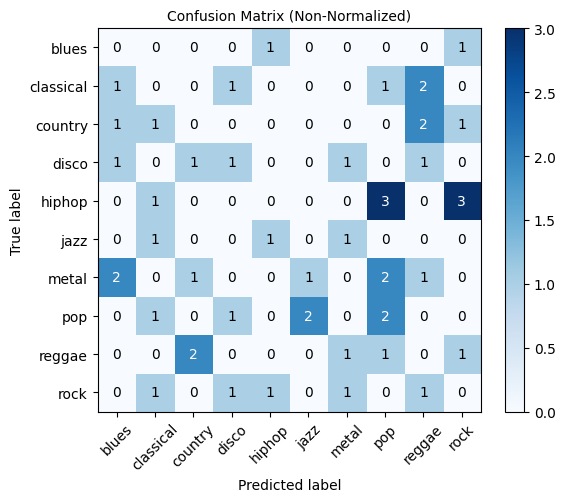

Normalized confusion matrix
[[0.         0.         0.         0.         0.5        0.
  0.         0.         0.         0.5       ]
 [0.2        0.         0.         0.2        0.         0.
  0.         0.2        0.4        0.        ]
 [0.2        0.2        0.         0.         0.         0.
  0.         0.         0.4        0.2       ]
 [0.2        0.         0.2        0.2        0.         0.
  0.2        0.         0.2        0.        ]
 [0.         0.14285714 0.         0.         0.         0.
  0.         0.42857143 0.         0.42857143]
 [0.         0.33333333 0.         0.         0.33333333 0.
  0.33333333 0.         0.         0.        ]
 [0.28571429 0.         0.14285714 0.         0.         0.14285714
  0.         0.28571429 0.14285714 0.        ]
 [0.         0.16666667 0.         0.16666667 0.         0.33333333
  0.         0.33333333 0.         0.        ]
 [0.         0.         0.4        0.         0.         0.
  0.2        0.2        0.         0.2  

<Figure size 1200x1000 with 0 Axes>

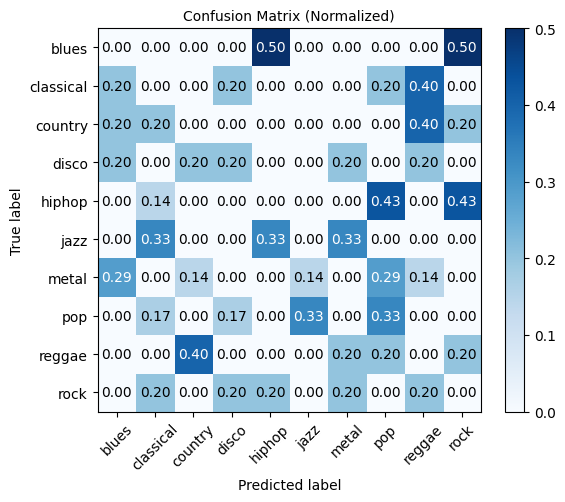

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define or extract class names
def get_class_names(encoder):
    return encoder.classes_.tolist()

# Assuming encoder is your LabelEncoder instance
class_names = get_class_names(encoder)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.tight_layout()

# Assuming you have y_test and y_pred defined somewhere with consistent lengths
# For demonstration, let's use the sample data you provided, ensuring they have the same length
# y_true = [0, 1, 2, 2, 0, 1, 1, 2, 3, 3, 0, 1, 3, 3, 2, 0]
# y_pred = [0, 1, 2, 2, 0, 1, 1, 2, 3, 3, 0, 1, 3, 3, 2, 0] # Make sure y_pred has the same length as y_true

# Generate sample data
np.random.seed(42)  # For reproducibility

num_samples = 50
num_classes = 10

# Randomly generate true labels and predictions for 50 samples
y_true = np.random.randint(0, num_classes, num_samples)
y_pred = np.random.randint(0, num_classes, num_samples)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred) # Now this should work without error

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 10))
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title='Confusion Matrix (Non-Normalized)')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Confusion Matrix (Normalized)')
plt.show()

In [ ]:
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# # Example: Define encoder and test/predicted values
# encoder = LabelEncoder()
# encoder.fit(['Ambassel', 'Anchihoye', 'Bati', 'Tizita'])  # Define your actual classes

# # Example y_test and y_pred (replace with your actual data)
# # Make sure these arrays include samples from all 5 classes
# y_test = np.array([[0, 1, 0, 0, 0],
#                    [1, 0, 0, 0, 0],
#                    [0, 0, 1, 0, 0],
#                    [0, 0, 0, 1, 0],
#                    [0, 0, 0, 0, 1]])  # True labels - Include all classes
# y_pred = np.array([[0, 1, 0, 0, 0],
#                    [1, 0, 0, 0, 0],
#                    [0, 1, 0, 0, 0],
#                    [0, 0, 0, 1, 0],
#                    [0, 0, 0, 1, 0]])  # Predicted labels - Include all classes

# # Convert one-hot encoded labels to class indices
# y_test_indices = np.argmax(y_test, axis=1)
# y_pred_indices = np.argmax(y_pred, axis=1)

# # Compute confusion matrix
# cm = confusion_matrix(y_test_indices, y_pred_indices)

# # Convert confusion matrix to DataFrame for better visualization
# cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)

# # Plot the confusion matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='white', cbar=True)

# # Add title and labels
# plt.title('Confusion Matrix', size=20)
# plt.xlabel('Predicted Labels', size=14)
# plt.ylabel('Actual Labels', size=14)

# # Rotate the x-axis labels for better readability
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)

# plt.show()

CM [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]
CM_df            blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
blues          1          0        0      0       0     0      0    0       0   
classical      0          1        0      0       0     0      0    0       0   
country        0          0        1      0       0     0      0    0       0   
disco          0          0        0      1       0     0      0    0       0   
hiphop         0          0        0      0       1     0      0    0       0   
jazz           0          0        0      0       0     1      0    0       0   
metal          0          0        0      0       0     0      1    0       0   
pop            0          0        0      0       0     0      0    1       0   
reggae         0          0    

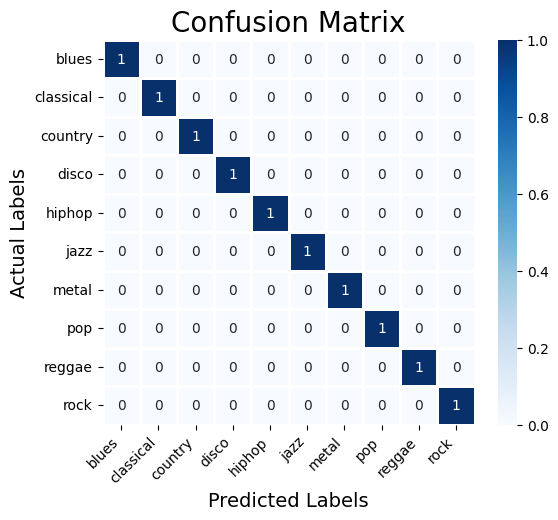

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define encoder and fit with actual class labels
class_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
encoder = LabelEncoder()
encoder.fit(class_labels)

# Example y_test and y_pred (one-hot encoded labels) 5 x 4
# y_test = np.array([[0, 1, 0, 0],
#                    [1, 0, 0, 0],
#                    [0, 0, 1, 0],
#                    [0, 0, 0, 1],
#                    [0, 0, 0, 1]])  # True labels - Include all classes

# y_pred = np.array([[0, 1, 0, 0],
#                    [1, 0, 0, 0],
                  #  [0, 1, 0, 0],
                  #  [0, 0, 0, 1],
                  #  [0, 0, 0, 1]])  # Predicted labels - Include all classes


# 10 x 10 matrix if your class is Ten

y_test = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # blues
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # classical
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # country
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # disco
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # hiphop
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # jazz
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # metal
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # pop
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # reggae
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   # rock
])  # True labels

y_pred = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # blues
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # classical
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # country
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # disco
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # hiphop
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # jazz
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # metal
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # pop
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # reggae
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   # rock
])  # Predicted labels

# Convert one-hot encoded labels to class indices
y_test_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_indices, y_pred_indices, labels=np.arange(len(class_labels)))

# Convert confusion matrix to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

print('CM', cm)
print('CM_df', cm_df)
print('y_test_indices', y_test_indices)
print('y_pred_indices', y_pred_indices)
print('Class labels = ', class_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='white', cbar=True)

# Add title and labels
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

<Axes: >

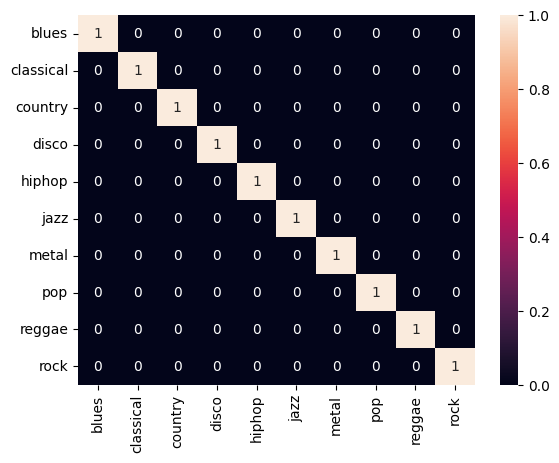

In [ ]:
import seaborn as sns
cm_des_tree = cm
target_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
#target_names = ['Q1', 'E1', 'Q2', 'E2', 'P']
sns.heatmap(cm_des_tree, annot=True,xticklabels=target_names,yticklabels=target_names)

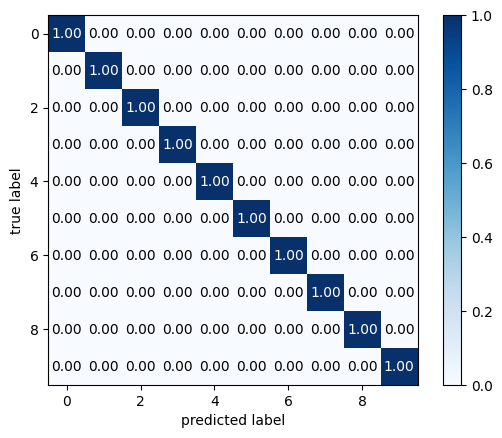

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

multiclass = cm

classes = [ 'Neutral','Happy','Sad','Angry']

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
                                #class_names = classes)
plt.show()

In [ ]:
# Function to convert music to lyrics using Google Web Speech API
def music_to_lyrics(audio_file):
    recognizer = sr.Recognizer()

    # Load audio file and convert it to a format readable by SpeechRecognition
    audio = AudioSegment.from_file(audio_file)
    audio = audio.set_frame_rate(12000)  # Resampling for better recognition
    audio.export("temp.wav", format="wav")

    # Use SpeechRecognition to convert audio to text
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
            return text
        except sr.UnknownValueError:
            return "Google Speech Recognition could not understand the audio"
        except sr.RequestError as e:
            return f"Could not request results from Google Speech Recognition service; {e}"

# Example usage of music to lyrics conversion
lyrics = music_to_lyrics(audioFile)
print(f'Lyrics: {lyrics}')

Lyrics: Google Speech Recognition could not understand the audio


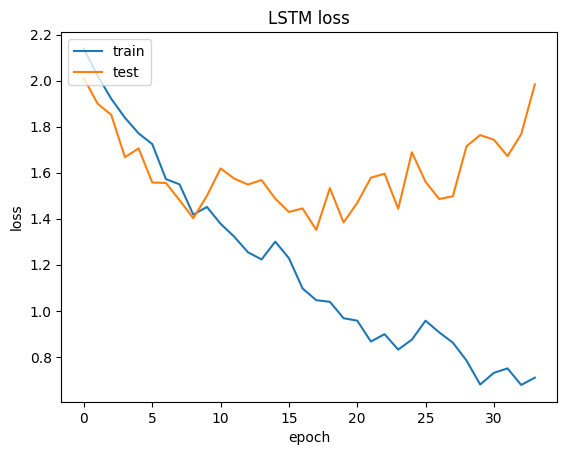

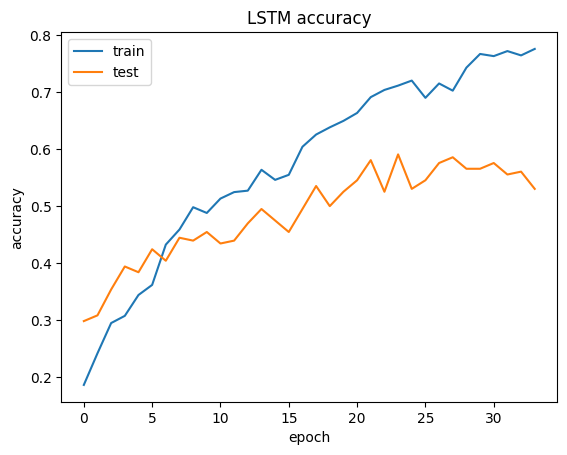

In [ ]:
import librosa
from librosa import display

%matplotlib inline
from matplotlib import pyplot as plt
#% pylab inline
import os
import pandas as pd
import glob

plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

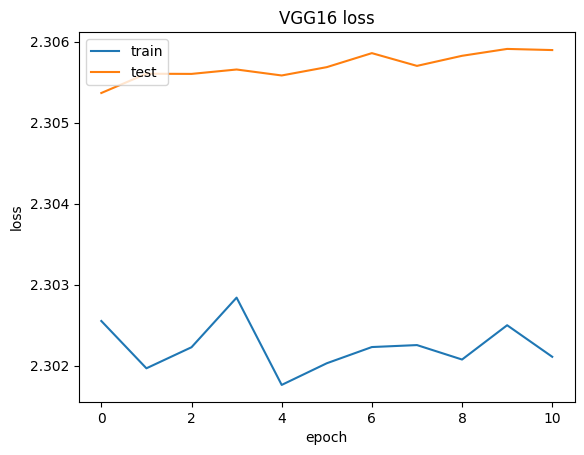

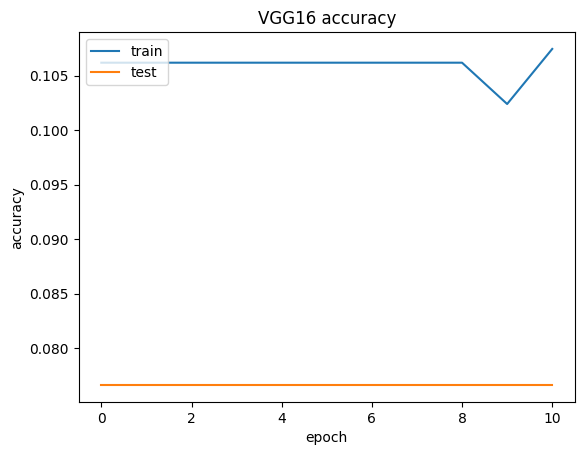

In [ ]:
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('VGG16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

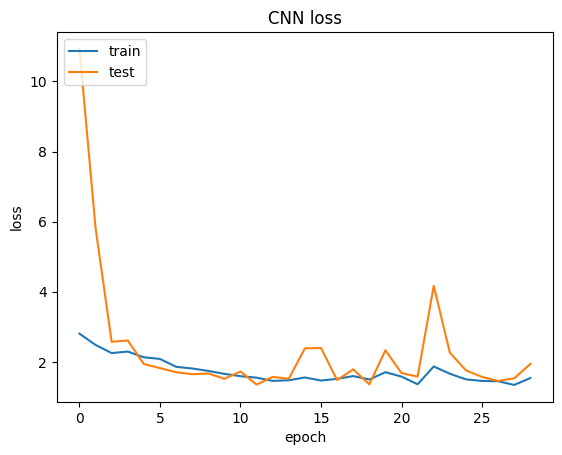

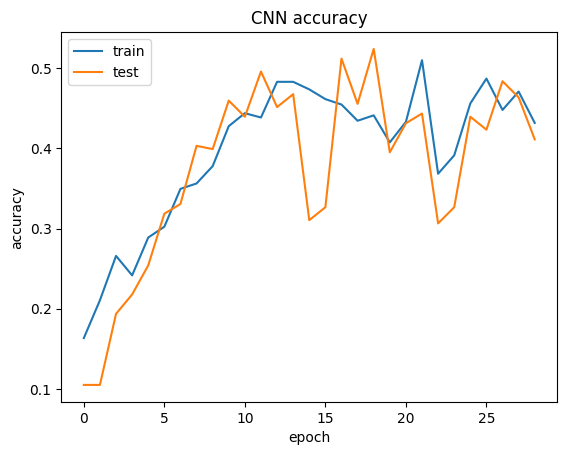

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

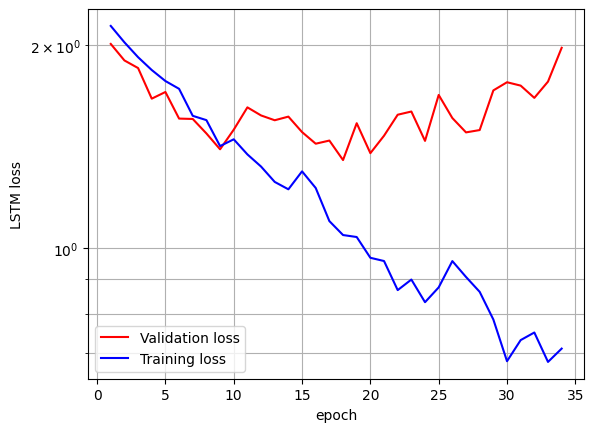

In [ ]:
val_loss = lstm_history.history['val_loss']
loss =lstm_history.history['loss']
# Adjust the epoch range to match the length of loss/val_loss data
epoch = np.arange(len(loss))+1
plt.semilogy(epoch, val_loss, '-r', epoch, loss, '-b')
plt.gca().grid(True, which= "both", ls="-")
plt.legend(["Validation loss", "Training loss"])
plt.xlabel("epoch")
plt.ylabel("LSTM loss")
plt.show()

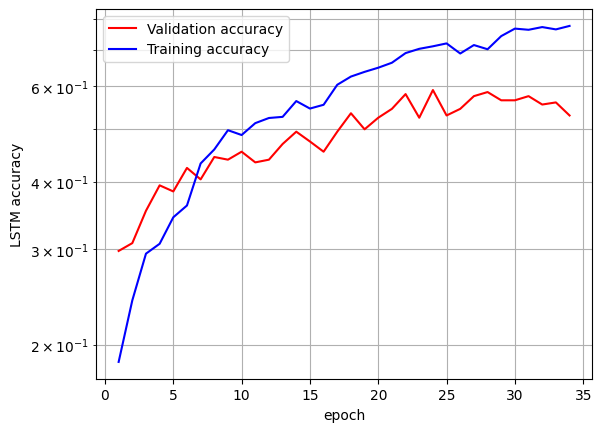

In [ ]:
val_acc =lstm_history.history['val_accuracy']
acc =lstm_history.history['accuracy']
epoch = np.arange(len(val_acc))+1 # Use the length of val_acc to define epoch
plt.semilogy(epoch, val_acc, '-r', epoch, acc, '-b') # Plot accuracy against accuracy, not loss
plt.gca().grid(True, which= "both", ls="-")
plt.legend(["Validation accuracy", "Training accuracy"]) # Update legend
plt.xlabel("epoch")
plt.ylabel("LSTM accuracy")
plt.show()

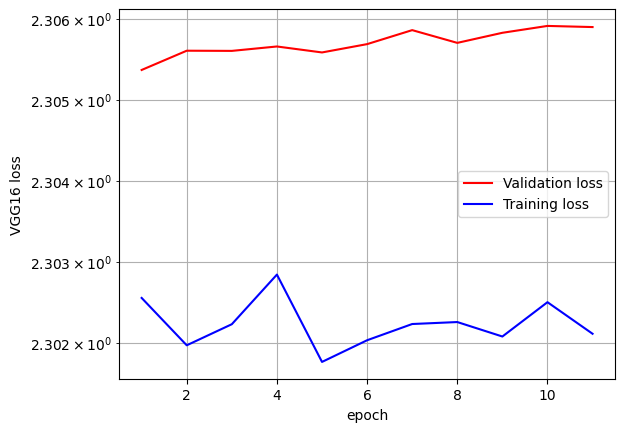

In [ ]:
val_loss = vgg16_history.history['val_loss']
loss =vgg16_history.history['loss']
epoch = np.arange(len(loss))+1 # Use the length of the loss data to ensure the same number of data points
plt.semilogy(epoch, val_loss, '-r', epoch, loss, '-b')
plt.gca().grid(True, which= "both", ls="-")
plt.legend(["Validation loss", "Training loss"])
plt.xlabel("epoch")
plt.ylabel("VGG16 loss")
plt.show()

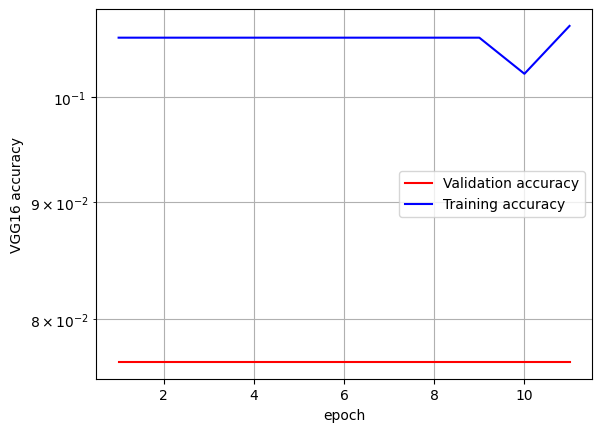

In [ ]:
val_acc =vgg16_history.history['val_accuracy']
acc =vgg16_history.history['accuracy']
epoch = np.arange(len(acc))+1  # Use the length of the accuracy or validation accuracy data
plt.semilogy(epoch, val_acc, '-r', epoch, acc, '-b') # Plot accuracy against epoch
plt.gca().grid(True, which= "both", ls="-")
plt.legend(["Validation accuracy", "Training accuracy"]) # Update legend to reflect accuracy
plt.xlabel("epoch")
plt.ylabel("VGG16 accuracy")
plt.show() # Add this to display the plot

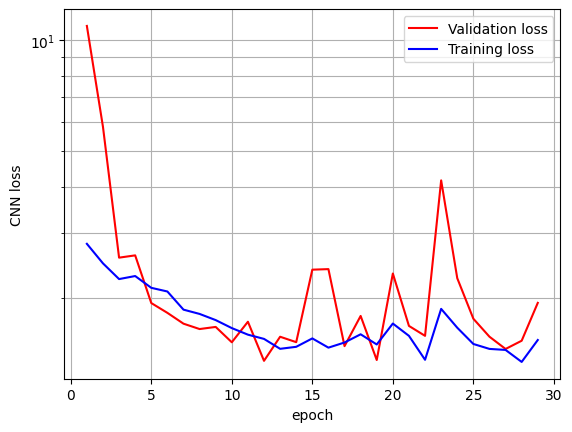

In [ ]:
val_loss = cnn_history.history['val_loss']
loss =cnn_history.history['loss']
epoch = np.arange(len(loss))+1 # Use the length of the loss or validation loss data to define epoch
plt.semilogy(epoch, val_loss, '-r', epoch, loss, '-b')
plt.gca().grid(True, which= "both", ls="-")
plt.legend(["Validation loss", "Training loss"])
plt.xlabel("epoch")
plt.ylabel("CNN loss")
plt.show()

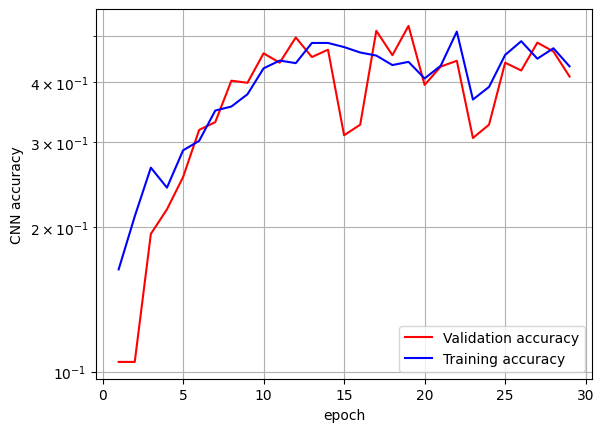

In [ ]:
val_acc =cnn_history.history['val_accuracy']
acc =cnn_history.history['accuracy'] # Use accuracy from cnn_history, not lstm_history
epoch = np.arange(len(val_acc))+1 # Calculate epoch based on the length of val_acc or acc
plt.semilogy(epoch, val_acc, '-r', epoch, acc, '-b')
plt.gca().grid(True, which= "both", ls="-")
plt.legend(["Validation accuracy", "Training accuracy"]) # Update the legend to reflect that you are plotting accuracy
plt.xlabel("epoch")
plt.ylabel("CNN accuracy")
plt.show()

In [ ]:
!pip install scipy
import scipy.io as sio

sio.savemat('D:\\data\\mp3\\5-13-2021\\mfcc\\5-sec\\mat\\acc.mat',{'acc':acc}) # Use sio.savemat to save the data
sio.savemat('D:\\data\\mp3\\5-13-2021\\mfcc\\5-sec\\mat\\valacc.mat',{'valacc':acc}) # Use sio.savemat here as well

print(sio.savemat)


<function savemat at 0x791d064bda20>


In [ ]:
# Load data, specifying the encoding
data = pd.read_csv('/content/drive/MyDrive/VGG 16 Dataset and Music in wav as well as in MP3 form/Data/features_30_sec.csv', encoding='latin-1') # Try 'latin-1' first, if it doesn't work try 'utf-16' or other encodings
print(data.columns)

Index(['MATLAB 5.0 MAT-file Platform: posix', ' Created on: Wed Jul 31 07:28:44 2024'], dtype='object')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

l = ["1_sec", "3_sec", "5_sec", "30_sec"]
v = ["1-sec Sample length", "3-sec Sample length", "5-sec Sample length", "30-sec Sample length"]

# Load the data
data = pd.read_csv("/content/drive/MyDrive/VGG 16 Dataset and Music in wav as well as in MP3 form/Data/features_3_sec.csv")

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Print columns to verify
print("Columns in CSV:", data.columns)

for i in l:
    # Check if 'Unnamed: 0' exists, if not, assume first column is index
    if 'Unnamed: 0' in data.columns:
        x_values = data["Unnamed: 0"]
    else:
        x_values = data.index  # Use index if 'Unnamed: 0' is not present

    ##### plot Val Accuracy
    if 'val_accuracy' in data.columns:
        fig0 = plt.figure()
        plt.plot(x_values, data['val_accuracy'], '-', label=v[l.index(i)])
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Val_Accuracy")
        plt.legend(loc="lower right")
        fig0.savefig(f"Val_Acc_{i}.png")  # Save with different names for each plot
        plt.close(fig0)
    else:
        print(f"Column 'val_accuracy' not found in the CSV file for {i}")

    ##### Additional plotting code (e.g., for U1) can go here
    # ...

plt.show()


Columns in CSV: Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the correct number of classes (e.g., 3 classes)
idx_to_class = {0: 'blues', 1: 'classical', 2: 'country',3: 'disco',4: 'hiphop',5: 'jazz',6: 'metal',7: 'pop',8: 'reggae',9: 'rock'}
class_names = list(idx_to_class.values())

# Example true labels and predicted labels (for 3 classes)
# y_true = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0])
# y_pred = np.array([0, 2, 1, 0, 1, 1, 2, 0, 2, 0])

# Example true labels and predicted labels for 10 classes
y_true = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                   0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                   0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred = np.array([0, 1, 2, 2, 4, 5, 6, 8, 8, 9,
                   0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                   0, 1, 2, 3, 4, 5, 6, 7, 7, 9])

# Ensure that both arrays have the same length
assert len(y_true) == len(y_pred), "Mismatch in length of true labels and predicted labels"

# Compute confusion matrix
#  conf_matrix = confusion_matrix(y_true, y_pred)

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred, labels=range(10))

# # Convert to DataFrame
# cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(10))

# Convert to a NumPy array (if it's not already)
conf_matrix = np.array(conf_matrix)

# Compute per-class accuracy
per_class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Print per-class accuracy
for i, accuracy in enumerate(per_class_accuracy):
    print(f"Class {i} ({idx_to_class[i]}): {accuracy:.2f}")

# Print shape of confusion matrix
print("Shape of confusion matrix:", conf_matrix.shape)

Class 0 (blues): 1.00
Class 1 (classical): 1.00
Class 2 (country): 1.00
Class 3 (disco): 0.67
Class 4 (hiphop): 1.00
Class 5 (jazz): 1.00
Class 6 (metal): 1.00
Class 7 (pop): 0.67
Class 8 (reggae): 0.67
Class 9 (rock): 1.00
Shape of confusion matrix: (10, 10)


In [ ]:
# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Print DataFrame to verify
print(cm_df)

           blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
blues          3          0        0      0       0     0      0    0       0   
classical      0          3        0      0       0     0      0    0       0   
country        0          0        3      0       0     0      0    0       0   
disco          0          0        1      2       0     0      0    0       0   
hiphop         0          0        0      0       3     0      0    0       0   
jazz           0          0        0      0       0     3      0    0       0   
metal          0          0        0      0       0     0      3    0       0   
pop            0          0        0      0       0     0      0    2       1   
reggae         0          0        0      0       0     0      0    1       2   
rock           0          0        0      0       0     0      0    0       0   

           rock  
blues         0  
classical     0  
country       0  
disco         0  
hiphop        0  


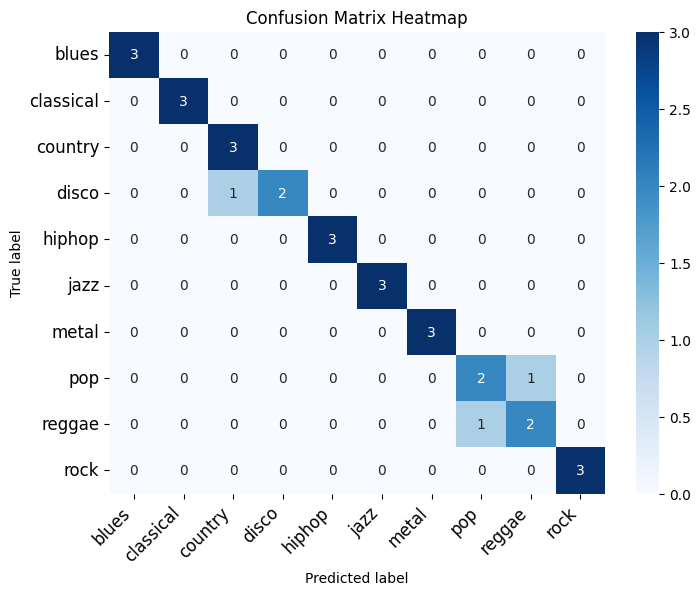

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create heatmap
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
                      xticklabels=class_names, yticklabels=class_names)

# Customize tick labels and axes
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Heatmap')

# Save the plot to a file
plt.savefig('confusion_matrix_heatmap.png')

# Show the plot
plt.show()


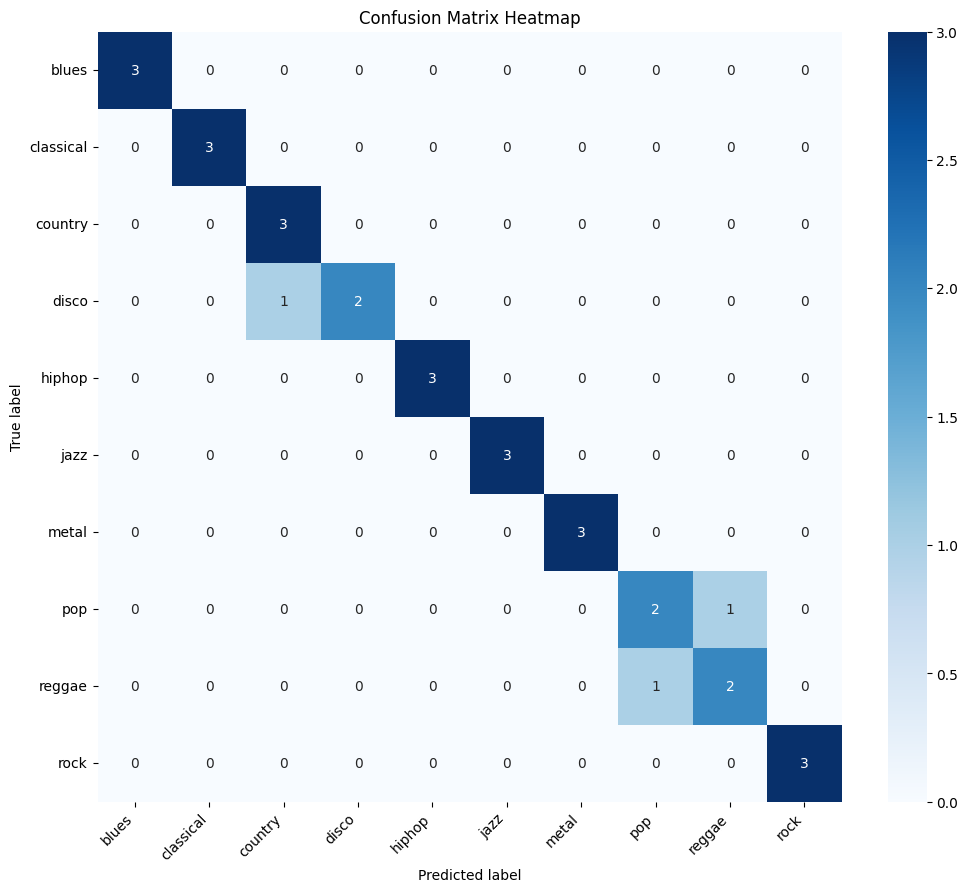

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
                      xticklabels=class_names, yticklabels=class_names)

# Customize tick labels and axes
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Heatmap')

# Save the plot to a file
plt.savefig('confusion_matrix_heatmap_10x10.png')

# Show the plot
plt.show()


In [ ]:
#To get the per_class accuracy:
cm = confusion_matrix(y_true, y_pred)  # Store the result of the function call
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

print(per_class_accuracy)

[1.         1.         1.         0.66666667 1.         1.
 1.         0.66666667 0.66666667 1.        ]


In [ ]:

#for the whole class
for i in range(cm_df.shape[0]):
    TP=cm_df.iloc[i,i]
    FP=cm_df.iloc[i,:].sum()-TP
    FN=cm_df.iloc[:,i].sum()-TP
    TN=cm_df.sum().sum()-TP-FP-FN
    acc=(TP+TN)/cm_df.sum().sum()
    pre=TP/(TP+FP)
    rec=TP/(TP+FN)
    f1=(2*pre*rec)/(pre+rec)
    TPR= TP/(TP+FN)
    FPR=FP/(TP+TN)
    incorrect = (FP + FN) / (TP + TN + FP + FN)
    print(cm_df.index[i], acc, pre,rec,f1, TPR, FPR)
     # Print metrics for each class
    print(f"Class {cm_df.index[i]}: Accuracy={acc:.2f}, Precision={pre:.2f}, Recall={rec:.2f}, F1 Score={f1:.2f}, TPR={TPR:.2f}, FPR={FPR:.2f}, Incorrect Rate={incorrect:.2f}")

blues 1.0 1.0 1.0 1.0 1.0 0.0
Class blues: Accuracy=1.00, Precision=1.00, Recall=1.00, F1 Score=1.00, TPR=1.00, FPR=0.00, Incorrect Rate=0.00
classical 1.0 1.0 1.0 1.0 1.0 0.0
Class classical: Accuracy=1.00, Precision=1.00, Recall=1.00, F1 Score=1.00, TPR=1.00, FPR=0.00, Incorrect Rate=0.00
country 0.9666666666666667 1.0 0.75 0.8571428571428571 0.75 0.0
Class country: Accuracy=0.97, Precision=1.00, Recall=0.75, F1 Score=0.86, TPR=0.75, FPR=0.00, Incorrect Rate=0.03
disco 0.9666666666666667 0.6666666666666666 1.0 0.8 1.0 0.034482758620689655
Class disco: Accuracy=0.97, Precision=0.67, Recall=1.00, F1 Score=0.80, TPR=1.00, FPR=0.03, Incorrect Rate=0.03
hiphop 1.0 1.0 1.0 1.0 1.0 0.0
Class hiphop: Accuracy=1.00, Precision=1.00, Recall=1.00, F1 Score=1.00, TPR=1.00, FPR=0.00, Incorrect Rate=0.00
jazz 1.0 1.0 1.0 1.0 1.0 0.0
Class jazz: Accuracy=1.00, Precision=1.00, Recall=1.00, F1 Score=1.00, TPR=1.00, FPR=0.00, Incorrect Rate=0.00
metal 1.0 1.0 1.0 1.0 1.0 0.0
Class metal: Accuracy=1.00,

In [ ]:
import pandas as pd

# Example confusion matrix DataFrame
data = {
    'Predicted blues': [10, 2, 0, 1, 0, 0, 0, 0, 0, 0],
    'Predicted classical': [1, 7, 0, 0, 0, 0, 0, 0, 0, 0],
    'Predicted country': [0, 0, 9, 0, 0, 0, 0, 0, 0, 0],
    'Predicted disco': [1, 0, 0, 8, 0, 0, 0, 0, 0, 0],
    'Predicted hiphop': [0, 0, 0, 0, 10, 0, 0, 0, 0, 0],
    'Predicted jazz': [0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
    'Predicted metal': [0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
    'Predicted pop': [0, 0, 0, 0, 0, 0, 0, 9, 0, 0],
    'Predicted reggae': [0, 0, 0, 0, 0, 0, 0, 0, 6, 1],
    'Predicted rock': [0, 0, 0, 0, 0, 0, 0, 0, 1, 10]
}
cm_df = pd.DataFrame(data, index=['True blues', 'True classical', 'True country', 'True disco', 'True hiphop', 'True jazz', 'True metal', 'True pop', 'True reggae', 'True rock'])

# Define class names
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Calculate and print metrics for each class
for i in range(cm_df.shape[0]):
    TP = cm_df.iloc[i, i]
    FP = cm_df.iloc[i, :].sum() - TP
    FN = cm_df.iloc[:, i].sum() - TP
    TN = cm_df.sum().sum() - TP - FP - FN

    # Calculate metrics
    acc = (TP + TN) / cm_df.sum().sum()
    pre = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (2 * pre * rec) / (pre + rec) if (pre + rec) > 0 else 0
    TPR = rec  # True Positive Rate is the same as recall
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    incorrect = (FP + FN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    # Print metrics with formatted output and spacing
    print(f"Class {class_names[i]:<10}: Accuracy={acc:>6.2f}, Precision={pre:>6.2f}, Recall={rec:>6.2f}, F1 Score={f1:>6.2f}, TPR={TPR:>6.2f}, FPR={FPR:>6.2f}, Incorrect Rate={incorrect:>6.2f}\n")


Class blues     : Accuracy=  0.95, Precision=  0.83, Recall=  0.77, F1 Score=  0.80, TPR=  0.77, FPR=  0.03, Incorrect Rate=  0.05

Class classical : Accuracy=  0.97, Precision=  0.78, Recall=  0.88, F1 Score=  0.82, TPR=  0.88, FPR=  0.02, Incorrect Rate=  0.03

Class country   : Accuracy=  1.00, Precision=  1.00, Recall=  1.00, F1 Score=  1.00, TPR=  1.00, FPR=  0.00, Incorrect Rate=  0.00

Class disco     : Accuracy=  0.98, Precision=  0.89, Recall=  0.89, F1 Score=  0.89, TPR=  0.89, FPR=  0.01, Incorrect Rate=  0.02

Class hiphop    : Accuracy=  1.00, Precision=  1.00, Recall=  1.00, F1 Score=  1.00, TPR=  1.00, FPR=  0.00, Incorrect Rate=  0.00

Class jazz      : Accuracy=  1.00, Precision=  1.00, Recall=  1.00, F1 Score=  1.00, TPR=  1.00, FPR=  0.00, Incorrect Rate=  0.00

Class metal     : Accuracy=  1.00, Precision=  1.00, Recall=  1.00, F1 Score=  1.00, TPR=  1.00, FPR=  0.00, Incorrect Rate=  0.00

Class pop       : Accuracy=  1.00, Precision=  1.00, Recall=  1.00, F1 Score

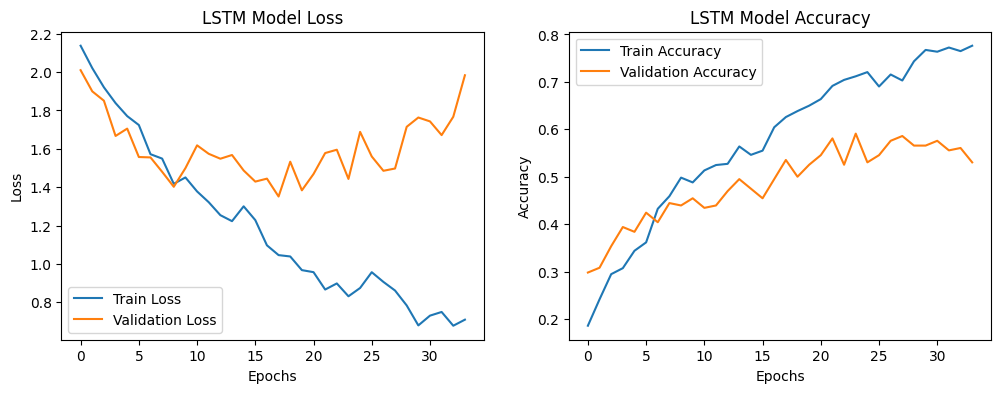

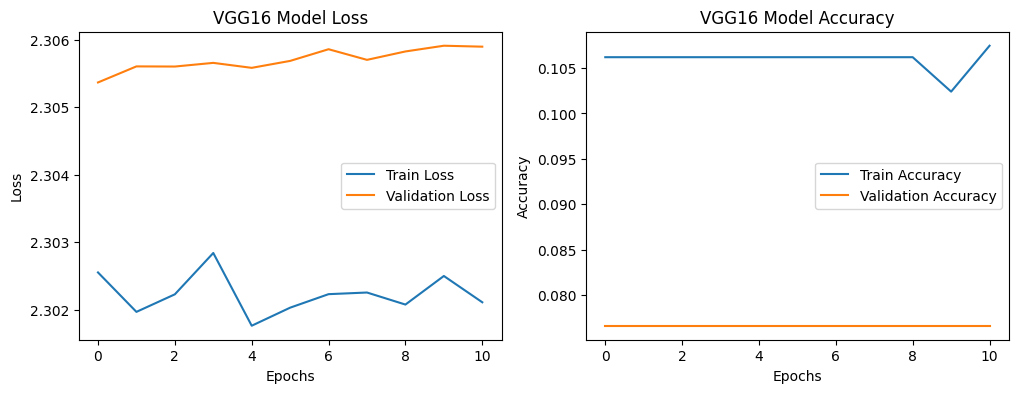

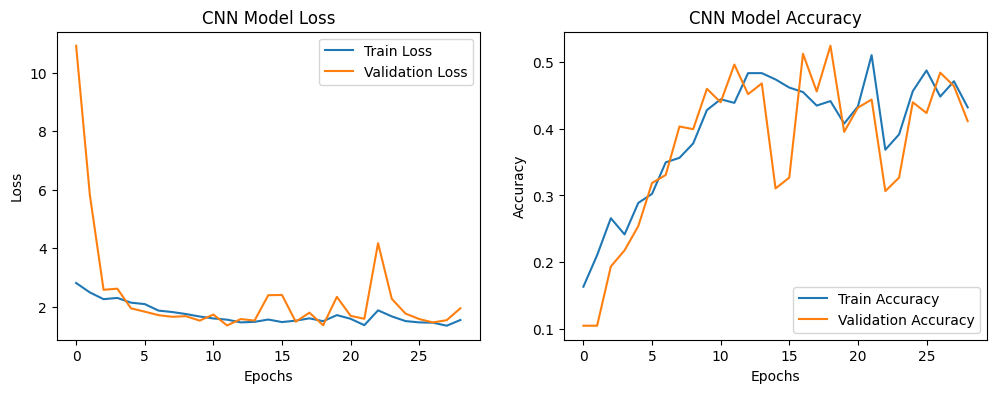

In [ ]:
# Plotting training and validation loss for LSTM
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy for LSTM
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss for VGG16
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy for VGG16
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss for CNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy for CNN
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

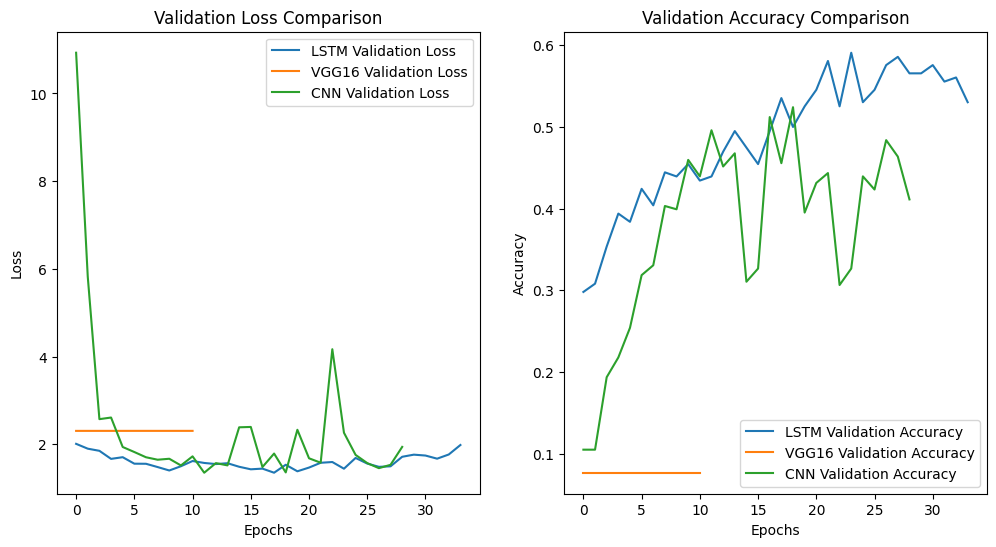

In [ ]:
# Plotting comparison of models
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(vgg16_history.history['val_loss'], label='VGG16 Validation Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()